In [1]:
import os
import json
import pandas as pd
from tqdm import tqdm

import numpy as np
import seaborn as sns

from transformers import AlbertTokenizerFast, ElectraTokenizerFast

from data.utils import get_data

In [2]:
train, val, test = get_data('snli_1.0')

In [3]:
train.head()

,sentence1,sentence2,target
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [5]:
albert_tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
electra_tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-base-discriminator')

In [6]:
albert_tokenizer.tokenize('Word embeddings are cool.', add_special_tokens=True)

['[CLS]', '▁word', '▁emb', 'ed', 'ding', 's', '▁are', '▁cool', '.', '[SEP]']

In [7]:
electra_tokenizer.tokenize('Word embeddings are cool.', add_special_tokens=True)

['[CLS]', 'word', 'em', '##bed', '##ding', '##s', 'are', 'cool', '.', '[SEP]']

In [8]:
def get_lengths_distribution(texts, tokenizer):
    lengths = [len(cached_tokenize(text, tokenizer)) for text in tqdm(texts)]
    sns.distplot(lengths);
    print(f'97th percentile is {np.percentile(lengths, 97)} tokens.')

In [9]:
CACHE = {}

def cached_tokenize(sentence, tokenizer):
    if (sentence, tokenizer.name_or_path) in CACHE:
        return CACHE[(sentence, tokenizer.name_or_path)]
    
    tokens = tokenizer.tokenize(sentence, add_special_tokens=True)
    CACHE[(sentence, tokenizer.name_or_path)] = tokens
    
    return tokens

100%|██████████| 550152/550152 [00:24<00:00, 22721.14it/s]


97th percentile is 31.0 tokens.


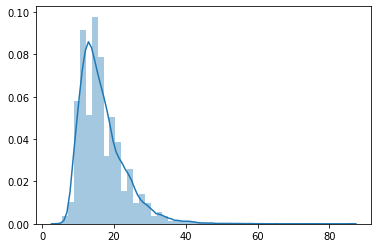

In [11]:
get_lengths_distribution(train.sentence1, albert_tokenizer)

100%|██████████| 550152/550152 [00:57<00:00, 9521.08it/s] 


97th percentile is 18.0 tokens.


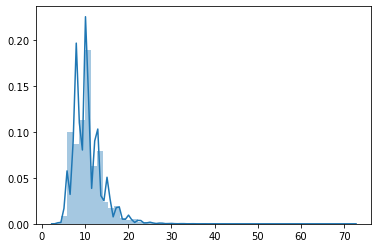

In [12]:
get_lengths_distribution(train.sentence2, albert_tokenizer)

100%|██████████| 550152/550152 [01:59<00:00, 4621.65it/s]


97th percentile is 44.0 tokens.


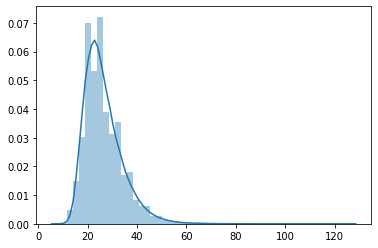

In [14]:
get_lengths_distribution([(x, y) for x, y in zip(train.sentence1, train.sentence2)], albert_tokenizer)

100%|██████████| 550152/550152 [00:19<00:00, 28213.97it/s]


97th percentile is 31.0 tokens.


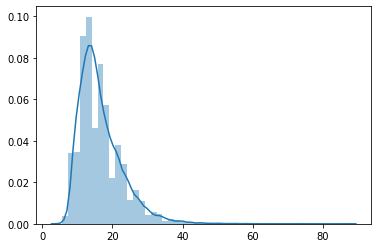

In [15]:
get_lengths_distribution(train.sentence1, electra_tokenizer)

100%|██████████| 550152/550152 [00:52<00:00, 10510.65it/s]


97th percentile is 18.0 tokens.


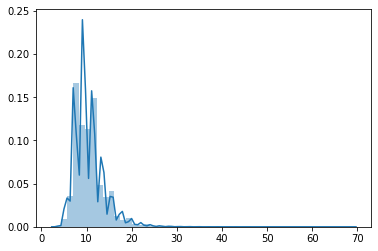

In [16]:
get_lengths_distribution(train.sentence2, electra_tokenizer)

100%|██████████| 550152/550152 [01:38<00:00, 5575.93it/s]


97th percentile is 44.0 tokens.


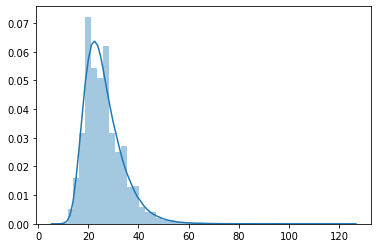

In [17]:
get_lengths_distribution([(x, y) for x, y in zip(train.sentence1, train.sentence2)], electra_tokenizer)

In [18]:
train.target.value_counts()

entailment       183416
contradiction    183187
neutral          182764
-                   785
Name: target, dtype: int64

## Takeaways

- we should filter out examples without a gold label
- it is fairly clear that all of our examples will be short enough for position embeddings, although it would be a good idea to use bucketing to improve training speed (since premises are usually longer, we will use their lengths for bucketing in case of a bi-encoder)
- Electra and Albert tokenizers are largely similar